>>>>> STARTING TEST 0 <<<<<
Step  1
367  Points
Step  2
400  Points
Step  3
408  Points
Step  4
406  Points
Step  5
414  Points
Step  6
408  Points
Step  7
396  Points
Step  8
412  Points
Step  9
412  Points
Step  10
390  Points
Step  11
371  Points
Step  12
382  Points
Step  13
410  Points
Step  14
422  Points
Step  15
388  Points
Step  16
420  Points
Step  17
401  Points
Step  18
390  Points
Step  19
416  Points
Step  20
414  Points
Step  21
386  Points
Step  22
413  Points
Step  23
394  Points
Step  24
387  Points
Step  25
388  Points
Step  26
397  Points
Step  27
401  Points
Step  28
391  Points
Step  29
386  Points
Step  30
402  Points
Step  31
395  Points
Step  32
398  Points
Step  33
401  Points
Step  34
388  Points
Step  35
398  Points
Step  36
393  Points
Step  37
388  Points
Step  38
392  Points
Step  39
395  Points
Step  40
398  Points
Step  41
394  Points
Step  42
396  Points
Step  43
394  Points
Step  44
400  Points
Step  45
406  Points
Step  46
417  Points
Step  47
403  P

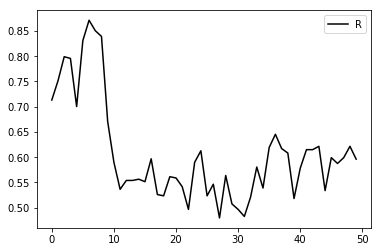

Average Accuracy:  0.620748756361
Standard Deviation:  0.134000427794
Variance:  0.0179561146491


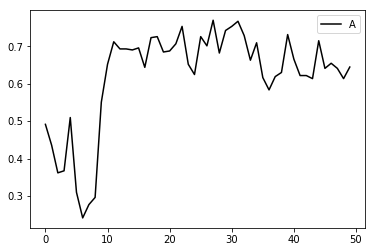

>>>>> END OF TEST 0 <<<<<


In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.neighbors.kde import KernelDensity
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from math import sqrt
from collections import Counter


def pca(X, numComponents):
    pca = PCA(n_components=numComponents)
    pca.fit(X)
    PCA(copy=True, iterated_power='auto', n_components=numComponents, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
    
    return pca.transform(X)
       
    
def kMeans(X, k):
    return KMeans(n_clusters=k).fit(X)


def svmClassifier(X, y):
    clf = svm.SVC()
    clf.fit(X, y)
    
    svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    
    return clf
    

def gmm(points):
    clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
    pdfs = np.exp(clf.fit(points).score_samples(points))
        
    return pdfs


def kde(points):
    kernel = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(points)
    pdfs = np.exp(kernel.score_samples(points))
    
    return pdfs


def baseClassifier(instancesToPredict, classifier):
    return classifier.predict(instancesToPredict)


def initializingData(X, y):
    c1=[]
    c2=[]
    for i in range(len(y)):
        if y[i]==0:
            c1.append(X[i])
        else:
            c2.append(X[i])
    
    return c1, c2
    
    
def loadDensitiesByClass(instances, indexesByClass, densityFunction):
    pdfsByClass = {}
    for c, indexes in indexesByClass.items():
        pdfs = [-1] * len(instances)
        points = instances[indexes]
        pdfsByPoints = densityFunction(points)
        a = 0
        for i in indexes:
            pdfs[i]=pdfsByPoints[a]
            a+=1
        pdfsByClass[c] = pdfs
        
    return pdfsByClass


#Slicing instances according to their inferred clusters
def slicingClusteredData(clusters, classes):
    indexes = {}
    for c in range(len(classes)):
        indexes[classes[c]]=[i for i in range(len(clusters)) if clusters[i] == c]
    
    return indexes


#Cutting data for next iteration
def compactingDataDensityBased(instances, densities, criteria):
    selectedInstances=[]
    for k in densities:
        arrPdf = densities[k]
        cutLine = max(arrPdf)*criteria
        selectedInstances.append([i for i in range(len(arrPdf)) if arrPdf[i] != -1 and arrPdf[i] >= cutLine ])
    
    return selectedInstances
    

def plotDistributions(distributions):
    i=0
    #ploting
    fig = plt.figure()
    handles = []
    colors = ['magenta', 'cyan']
    classes = ['cluster 1', 'cluster 2']
    ax = fig.add_subplot(121)
    
    for X in distributions:
        #reducing to 2-dimensional data
        x=pca(X, 2)
        
        handles.append(ax.scatter(x[:, 0], x[:, 1], color=colors[i], s=5, edgecolor='none'))
        i+=1
    
    ax.legend(handles, classes)
    
    plt.show()
    
    
def plotDistributionByClass(instances, indexesByClass):
    i=0
    #ploting
    fig = plt.figure()
    handles = []
    colors = ['magenta', 'cyan']
    classes = ['cluster 1', 'cluster 2']
    ax = fig.add_subplot(121)
    
    for c, indexes in indexesByClass.items():
        X = instances[indexes]
        #reducing to 2-dimensional data
        x=pca(X, 2)
        
        handles.append(ax.scatter(x[:, 0], x[:, 1], color=colors[i], s=5, edgecolor='none'))
        i+=1
    
    ax.legend(handles, classes)
    
    plt.show()
    
    
def evaluate(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    acc = accuracy_score(y_actual, y_predicted)
    #print("RMSE: ", rmse)
    return [rmse, acc]
    

def finalEvaluation(arrRmse, arrAcc):
    print("Average RMSE: ", np.mean(arrRmse))
    print("Standard Deviation: ", np.std(arrRmse))
    print("Variance: ", np.std(arrRmse)**2)
    plotAccuracy(arrRmse, 'RMSE')
    
    print("Average Accuracy: ", np.mean(arrAcc))
    print("Standard Deviation: ", np.std(arrAcc))
    print("Variance: ", np.std(arrAcc)**2)
    plotAccuracy(arrAcc, 'Accuracy')
    
    
def plotAccuracy(arr, label):
    c = range(len(arr))
    fig = plt.figure()
    fig.add_subplot(122)
    ax = plt.axes()
    
    ax.legend(ax.plot(c, arr, 'k'), label)
    plt.show()


def majorityVote(clusteredData, clusters, y):
    kPredicted = []
    '''print("Unlabeled: ", clusteredData)
    print("Cluster: ", clusters)
    print("labels de X: ", y)'''
    for i in range(len(clusteredData)):
        group = clusteredData[i]
        #print("Grupo: ", group)
        ind = np.where(clusters==group)
        #print("Indices: ", ind)
        label = y[ind]
        #print("labels: ",label)
        voting = Counter(label).most_common(1)[0][0]
        #print(voting)
        kPredicted.append(voting)
    
    return kPredicted


def clusterAndLabel(X, y, ut, K):
    arrPredicted=[-1]*len(ut)
    
    for k in range(2, K+2):
        kmeans = kMeans(pca(X, 2), k)
        clusters = kmeans.labels_
        clusteredData = baseClassifier(pca(ut, 2), kmeans)
        arrPredicted=np.vstack([arrPredicted, majorityVote(clusteredData, clusters, y)])
    
    labels=[]
    for j in range(len(ut)):
        labels.append(Counter(arrPredicted[:, j]).most_common(1)[0][0])
    
    return labels
    
    
def test0(dataValues, dataLabels, densityFunction='gmm', excludingPercentage = 0.2, batches = 50, sizeOfBatch = 365, initialLabeledDataPerc=0.05):
    print(">>>>> STARTING TEST 0 <<<<<")
    sizeOfLabeledData = round((initialLabeledDataPerc)*sizeOfBatch)
    initialDataLength = sizeOfLabeledData
    finalDataLength = sizeOfBatch
    K = 5
    classes = [0,1]
    arrRmse = []
    arrAcc = []
    
    # ***** Box 1 *****
    X = dataValues.loc[:initialDataLength].copy()
    X = X.values
    y = dataLabels.loc[:initialDataLength].copy()
    y = y.values[: , 0]
    
    #Starting the process
    for t in range(batches):
        #print("Step ",t+1)
        
        # ***** Box 2 *****
        U = dataValues.loc[initialDataLength:finalDataLength].copy()
        Ut = U.values

        # ***** Box 3 *****
        predicted = clusterAndLabel(X, y, Ut, K)
        instances = np.vstack([X, Ut])
        labelsInstances = np.hstack([y, predicted])
        # ***** Evaluating *****
        #print(len(instances), " Points")
        yt = dataLabels.loc[initialDataLength:finalDataLength].copy()
        yt = yt.values
        arrRmse.append(evaluate(yt, predicted)[0])
        arrAcc.append(evaluate(yt, predicted)[1])
        
        # ***** Box 4 *****
        indexesByClass = slicingClusteredData(labelsInstances, classes)
        
        pdfByClass=''
        if densityFunction == 'gmm':
            pdfByClass = loadDensitiesByClass(instances, indexesByClass, gmm)
        elif densityFunction == 'kde':
            pdfByClass = loadDensitiesByClass(instances, indexesByClass, kde)
        else:
            print ("Choose between 'gmm' or 'kde' function. Wrong name given: ", densityFunction)
            return 
        
        #Plotting data distribution by class
        #plotDistributionByClass(instances, indexesByClass)
        
        # ***** Box 5 *****
        selectedIndexes = compactingDataDensityBased(instances, pdfByClass, excludingPercentage)
        #X_class1 = selectedIndexes[0]
        #X_class2 = selectedIndexes[1]
        selectedIndexes = np.hstack([selectedIndexes[0],selectedIndexes[1]])
        
        # ***** Box 6 *****
        instances = np.array(instances)
        labelsInstances = np.array(labelsInstances)            
        X = instances[selectedIndexes]
        y = labelsInstances[selectedIndexes]      
        #updating indexes
        initialDataLength=finalDataLength+1
        finalDataLength+=sizeOfBatch
        
        
    finalEvaluation(arrRmse, arrAcc)
    print(">>>>> END OF TEST 0 <<<<<")
        

def test1(dataValues, dataLabels, classifier='kmeans', batches = 50, sizeOfBatch = 365, initialLabeledDataPerc=0.05):
    print(">>>>> STARTING TEST 1 <<<<<")
    sizeOfLabeledData = round((initialLabeledDataPerc)*sizeOfBatch)
    initialDataLength = sizeOfLabeledData
    finalDataLength = sizeOfBatch
    classes=[0, 1]
    
    X = dataValues.loc[:initialDataLength].copy()
    X = X.values
    y = dataLabels.loc[:initialDataLength].copy()
    y = y.values
    
    arrRmse = []
    arrAcc = []
    
    for t in range(batches):
        #print("Step ",t+1)
        
        U = dataValues.loc[initialDataLength:finalDataLength].copy()
        Ut = U.values
        yt = dataLabels.loc[initialDataLength:finalDataLength].copy()
        yt = yt.values
        predicted=[]
        
        if classifier == 'kmeans':
            kmeans = kMeans(pca(X, 2), classes)
            predicted = baseClassifier(pca(Ut, 2), kmeans)
        elif classifier == 'svm':
            svmClf = svmClassifier(pca(X, 2), y)
            predicted = baseClassifier(pca(Ut, 2), svmClf)
        else:
            return
        
        arrRmse.append(evaluate(yt, predicted)[0])
        arrAcc.append(evaluate(yt, predicted)[1])
        initialDataLength=finalDataLength+1
        finalDataLength+=sizeOfBatch
        # keep a percentage from former distribution to train in next step 
        #X = Ut
        #y = yt
    
    print(finalEvaluation(arrRmse, arrAcc))
    
    print(">>>>> END OF TEST 1 <<<<<")

    
def test2(dataValues, dataLabels):
    pass
    
    
def main():
    #os.chdir('..')
    #\\Convidado\\Documents\\GitHub\\Systems-Engineering\\Dissertation
    path = os.getcwd()+'\\datasets\\'
    '''
    Reading NOAA dataset:
    Eight  features  (average temperature, minimum temperature, maximum temperature, dew
    point,  sea  level  pressure,  visibility,  average wind speed, maximum  wind  speed)
    are  used  to  determine  whether  each  day  experienced  rain  or no rain.
    '''
    dataValues = pd.read_csv(path+'noaa_data.csv',sep = ",")
    dataLabels = pd.read_csv(path+'noaa_label.csv',sep = ",")
    #Test sets: Predicting 365 instances by step. 50 steps. Starting labeled data with 5% of 365 instances.
    ''' 
    Test 0: 
    Two classes.
    K-Means + GMM / KDE
    '''
    test0(dataValues, dataLabels, 'gmm', excludingPercentage = 0.3)
    '''
    Test 1:
    Two classes.
    K-Means / SVM
    '''
    test1(dataValues, dataLabels, 'kmeans')



main()

TypeError: list indices must be integers or slices, not tuple

In [58]:
import numpy as np
a = np.array([(1, 4), (2, 5), (3, 6)])
print(a[:, 0])

[1 2 3]
